# Demonstration using NEURON + Python

This jupyter notebook requires a valid installation of [NEURON](https://github.com/nrnhines/nrn) with python configured. 

### 1. Download a neuron morphology and electrical model from ModelDB

This model is open source and provided by the Allen Brain Institute

In [1]:
! wget "https://senselab.med.yale.edu/modeldb/eavBinDown.cshtml?o=184167&a=311&mime=application/zip"

--2017-09-26 11:31:15--  https://senselab.med.yale.edu/modeldb/eavBinDown.cshtml?o=184167&a=311&mime=application/zip
Resolving senselab.med.yale.edu (senselab.med.yale.edu)... 128.36.64.81
Connecting to senselab.med.yale.edu (senselab.med.yale.edu)|128.36.64.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 227141 (222K) [application/zip]
Saving to: ‘eavBinDown.cshtml?o=184167&a=311&mime=application%2Fzip’

eavBinDown.cshtml?o 100%[===================>] 221.82K   370KB/s    in 0.6s    

2017-09-26 11:31:16 (370 KB/s) - ‘eavBinDown.cshtml?o=184167&a=311&mime=application%2Fzip’ saved [227141/227141]



In [2]:
! mv "eavBinDown.cshtml?o=184167&a=311&mime=application%2Fzip" neuron.zip

In [3]:
! unzip neuron.zip

Archive:  neuron.zip
   creating: 472300877converted/
  inflating: 472300877converted/readme.html  
   creating: 472300877converted/modfiles/
  inflating: 472300877converted/modfiles/Im.mod  
  inflating: 472300877converted/modfiles/NaTa.mod  
  inflating: 472300877converted/modfiles/K_P.mod  
  inflating: 472300877converted/modfiles/Ca_HVA.mod  
  inflating: 472300877converted/modfiles/NaTs.mod  
  inflating: 472300877converted/modfiles/Kv3_1.mod  
  inflating: 472300877converted/modfiles/K_T.mod  
  inflating: 472300877converted/modfiles/Im_v2.mod  
  inflating: 472300877converted/modfiles/Ca_LVA.mod  
  inflating: 472300877converted/modfiles/Kv2like.mod  
  inflating: 472300877converted/modfiles/NaV.mod  
  inflating: 472300877converted/modfiles/SK.mod  
  inflating: 472300877converted/modfiles/Kd.mod  
  inflating: 472300877converted/modfiles/Nap.mod  
  inflating: 472300877converted/modfiles/Ih.mod  
  inflating: 472300877converted/modfiles/CaDynamics.mod  
  inflating: 472300877c

In [4]:
! mv 472300877converted AllenBrainNeuron

### 2. Download our special synapse model

This model is very likely open source. Anyways, use with care. 

#### To download the model, replace <user> below with your username 

In [5]:
! git clone ssh://<user>@bbpcode.epfl.ch/sim/neurodamus/bbp neurodamus

Cloning into 'neurodamus'...
remote: Counting objects: 16285, done
remote: Finding sources: 100% (16285/16285)
remote: Total 16285 (delta 10349), reused 16185 (delta 10349) 
Receiving objects: 100% (16285/16285), 48.33 MiB | 14.61 MiB/s, done.
Resolving deltas: 100% (10349/10349), done.
Checking connectivity... done.


In [6]:
! mv neurodamus/lib/modlib/ProbAMPANMDA_EMS.mod AllenBrainNeuron/modfiles

In [7]:
import os

In [8]:
os.chdir('AllenBrainNeuron')

### 3. Generate ion channel and synapse C files for NEURON

In [9]:
! nrnivmodl modfiles

Creating x86_64 directory for .o files.

/home/cremones/sandbox/jupyter-notebook-for-Tristan/AllenBrainNeuron
ls: cannot access 'modfiles/*.inc': No such file or directory
modfiles/CaDynamics.mod modfiles/Ca_HVA.mod modfiles/Ca_LVA.mod modfiles/Ih.mod modfiles/Im.mod modfiles/Im_v2.mod modfiles/Kd.mod modfiles/K_P.mod modfiles/K_T.mod modfiles/Kv2like.mod modfiles/Kv3_1.mod modfiles/Nap.mod modfiles/NaTa.mod modfiles/NaTs.mod modfiles/NaV.mod modfiles/ProbAMPANMDA_EMS.mod modfiles/SK.mod
CaDynamics.mod Ca_HVA.mod Ca_LVA.mod Ih.mod Im.mod Im_v2.mod Kd.mod K_P.mod K_T.mod Kv2like.mod Kv3_1.mod Nap.mod NaTa.mod NaTs.mod NaV.mod ProbAMPANMDA_EMS.mod SK.mod
"/home/cremones/soft/nrn/install/x86_64/bin/nocmodl" CaDynamics
Translating CaDynamics.mod into CaDynamics.c
Thread Safe
"/home/cremones/soft/nrn/install/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/cremones/soft/nrn/install/include/nrn" -I"/home/cremones/soft/nrn/install/x86_64/lib"      -g -O2 -c 

libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/cremones/soft/nrn/install/include/nrn -I/home/cremones/soft/nrn/install/x86_64/lib -g -O2 -c NaV.c  -fPIC -DPIC -o .libs/NaV.o
"/home/cremones/soft/nrn/install/x86_64/bin/nocmodl" ProbAMPANMDA_EMS
Translating ProbAMPANMDA_EMS.mod into ProbAMPANMDA_EMS.c
Notice: This mechanism cannot be used with CVODE
Notice: A_AMPA discontinuity adjustment not available.
Notice: B_AMPA discontinuity adjustment not available.
Notice: A_NMDA discontinuity adjustment not available.
Notice: B_NMDA discontinuity adjustment not available.
Thread Safe
"/home/cremones/soft/nrn/install/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/cremones/soft/nrn/install/include/nrn" -I"/home/cremones/soft/nrn/install/x86_64/lib"      -g -O2 -c -o ProbAMPANMDA_EMS.lo ProbAMPANMDA_EMS.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/cremones/soft/nrn/install/include/nrn -I/home/cremones/soft/nrn/install/x86_64/lib -g -O2

### 4. Definition of simulation parameters

In [30]:
import neuron
from neuron import h,gui
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import numpy as np

In [31]:
sys.path.append(os.getcwd())
from neuron472300877 import Neuron472300877 as Cell

In [32]:
junction_potential = -14.0
h.tstop = 550
h.celsius = 34.0

In [67]:
cell = Cell()

In [69]:
# setup recording
n_rec = 1
t = h.Vector()
t.record(h._ref_t)
rec_vec = []
for i in range(n_rec):
    rec_vec.append( h.Vector() )
    rec_vec[-1].record(cell.soma[i](0.5)._ref_v)

### 5. Place some synapses at random dendritic locations

In [70]:
synlist = []
NSYN = 10

In [71]:
for i in range(NSYN):
    target = np.random.randint(len(cell.dend))
    synlist.append( h.ProbAMPANMDA_EMS(0.5, sec=cell.dend[target]) )

In [72]:
stimlist = []
NSTIM = NSYN

### 6. Define how to stimulate those synapses

In [73]:
for i in range(NSTIM):
    stim = h.NetStim()
    stim.start = np.random.normal(20.0,2.0)
    stim.noise = 1.0
    stim.interval = 100.0
    stim.number = 1e+9
    stimlist.append(stim)

In [74]:
nclist = []
w = 5.0

In [75]:
for syn, stim in zip(synlist[:-1], stimlist[:-1]):
    ncstim = h.NetCon(stim, syn)
    ncstim.delay = 1.
    ncstim.weight[0] = w
    nclist.append(ncstim)

### 7. Tell NEURON we want to record from every synapse

In [91]:
t_vec = h.Vector()
id_vec = h.Vector()
for i in range(len(nclist)):
    nclist[i].record(t_vec, id_vec, i)

### 8. Initialize simulation state

In [92]:
h.v_init = -88.734330774000796
h.init()
h.finitialize()

1.0

### 9. Simulate!

In [93]:
h.tstop = 100
h.batch_run(100., 1./h.steps_per_ms)

1.0

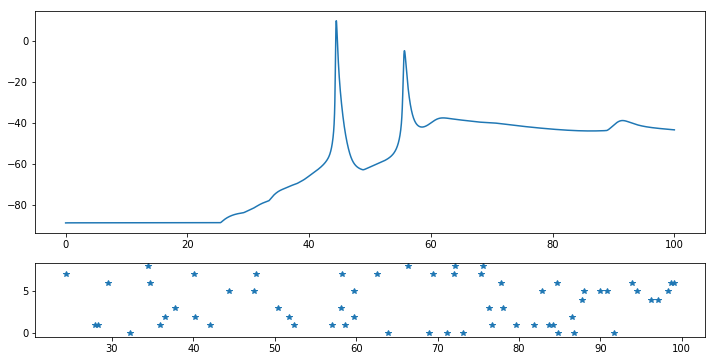

In [102]:
from matplotlib import gridspec
fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
for i in range(n_rec):
    ax0.plot(t,rec_vec[i],'-')
ax1 = plt.subplot(gs[1])
ax1.plot(t_vec.to_python(), id_vec.to_python(), '*')

### 10. Change some simulation parameters

Here we increase the frequency of stimulation of synapses

In [108]:
for i in range(NSTIM):
    stimlist[i].interval = 1.0

In [109]:
h.v_init = -88.734330774000796
h.init()
h.finitialize()

1.0

In [110]:
h.tstop = 100
h.batch_run(100., 1./h.steps_per_ms)

1.0

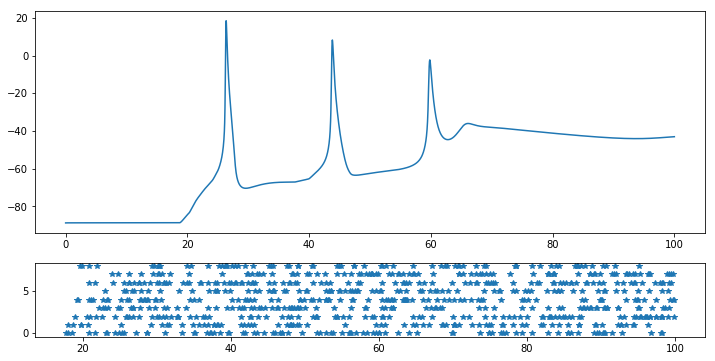

In [111]:
fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
for i in range(n_rec):
    ax0.plot(t,rec_vec[i],'-')
ax1 = plt.subplot(gs[1])
ax1.plot(t_vec.to_python(), id_vec.to_python(), '*')